Sampling Inference의 필요성 : 수식이 복잡할때 확률값의 analytic한 추론이 불가능. 

특정 분포에서 표본을 무수히 추출하는 방식으로 근사시켜 계산함(Monte Carlo)

## 0. Inverse Transform Method : 난수(Unif) -> 표본(특정분포)

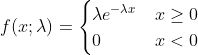

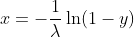

In [1]:
import numpy as np
import matplotlib.pyplot as plt

NUM_SAMPLES = 10000
RATE = 1.5

def exp_distr(x:np.ndarray, rate:float) -> np.ndarray:
  return rate * np.exp(-x * rate)

def exp_distr_sampled(num_samples: int, rate: float) -> np.ndarray:
  x = np.random.uniform(0,1,num_samples)
  return -1 / rate * np.log(1-x)

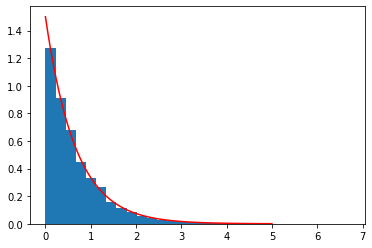

In [2]:
x = np.linspace(0,5,NUM_SAMPLES)
y_true = exp_distr(x, RATE)
y_sampled = exp_distr_sampled(NUM_SAMPLES, RATE)

plt.plot(x, y_true, "r-")
plt.hist(y_sampled, bins=30, density=True)
plt.show()

### **통계계산방법 Review**

✅ inverse CDF form is KNOWN : Inverse Transform Method  : Inverse CDF 는 항상 Uniform Dist.의 형태로 나타난다.

✅inverse CDF form is UNKNOWN : 

- Box-Muller 변환(정규분포)

- MCMC(Markov Chain Monte Carlo)

✅Sampling(random number generation) techniques : rng하기 어려운 형태일때

- method of composition : 쉽게 뽑을수 있는 **조건부확률**의 형태로 바꿔서 rng

- rejection sampling : 쉽게 뽑을수 있는 candidate distribution에 관한 식으로 바꿔서 candidate dist.에서 rng

- Monte Carlo Integration : 식을 분해해서 기댓값의 형태로 변환해서 rng

## 1. Rejection Sampling

✅어떨때 사용되는가?

주어진 확률분포 p의 pdf를 알고 있어야 한다.

주어진 확률분포 p에서 샘플을 생성하는 것이 어려울때(복잡한 경우)

✅어떻게 해결하는가?

쉽게 생성할 수 있는 envelope function q에서 샘플을 생성한 뒤, 이 샘플들의 분포가 p를 따르도록 수정한다. 

이때 추출된 샘플 $x_i$가  p분포를 따르도록 해야하므로, p분포는 KNOWN이어야 하며, 이것을 $p(x_i)$ 로 구현한다.

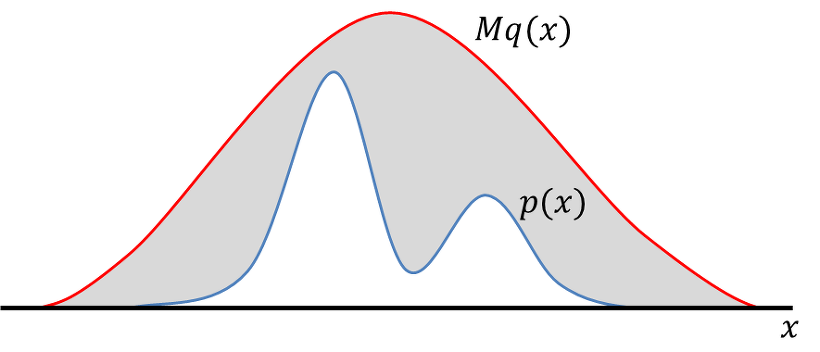

빠르게 샘플을 생성하는 accept rate를 설정하기 위해서는, $p(x_i) < Mq(x_i)$ 를 만족하면서 가능한 작은 M : $min(M)$을 선택해야 한다.



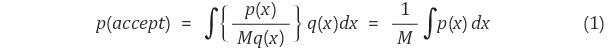

In [5]:
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from scipy.stats import truncnorm

In [6]:
xdomain = [-3,3]

In [11]:
def pdf(x): # standard normal distribution # p(x)
  return truncnorm.pdf(x,xdomain[0],xdomain[1])

In [14]:
def random_point_within_enveloping_region(): # Mq(x)
  x = random.uniform(xdomain[0],xdomain[1])
  y = random.uniform(0,0.5)
  return(x,y) 

In [21]:
# number of sample points to sample
n = 300

accepted = []
rejected = []

In [22]:
# accept/reject algorithm
while len(accepted) < n:
  x,y = random_point_within_enveloping_region()
  if y < pdf(x): # if y is inside p(x) (target function)
    accepted.append((x,y))
  else:
    rejected.append((x,y))


<ipython-input-28-9355031e2cbc>:5: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  plt.plot([x[0] for x in accepted], [x[1] for x in accepted] , 'ro', color='g') # Plot Accepted Points
<ipython-input-28-9355031e2cbc>:6: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  plt.plot([x[0] for x in rejected], [x[1] for x in rejected] , 'ro', color='r') # Plot Rejected Points


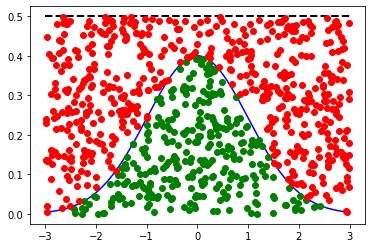

In [28]:
x = np.linspace(-3, 3, 300)
plt.plot(x, [pdf(i) for i in x], color='blue') # Plot Random Variable X
plt.plot(x, [0.5 for i in x], color='black', ls='dashed', lw=2) # Plot Enveloping 

plt.plot([x[0] for x in accepted], [x[1] for x in accepted] , 'ro', color='g') # Plot Accepted Points
plt.plot([x[0] for x in rejected], [x[1] for x in rejected] , 'ro', color='r') # Plot Rejected Points
plt.show()

In [29]:
approxMean = sum([x[0] for x in accepted])/len(accepted)
print ("Expected Mean = ", 0, pdf(0))
print ("Approximated Mean = ", approxMean, pdf(approxMean))
print ("Approximated Variance = ", sum([(x[0] - approxMean)**2 for x in accepted])/(len(accepted)-1))

Expected Mean =  0 0.40002225892128485
Approximated Mean =  -0.08947452230432384 0.39842423225427137
Approximated Variance =  0.9124195016839286


In [30]:
len(accepted)

300

In [31]:
len(rejected)

522

## 2. Importance Sampling

✅어떨때 사용되는가?

주어진 확률분포 p의 pdf를 알고 있어야 한다.

주어진 확률분포 p에서 샘플을 생성하는 것이 어려울때

✅어떻게 해결하는가?

쉽게 생성할 수 있는 q에서 샘플을 생성한 뒤, p의 기댓값을 계산한다.

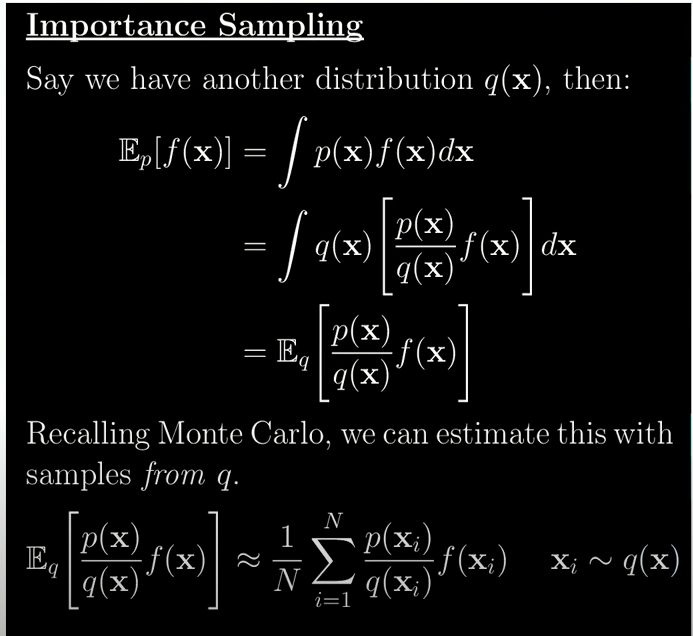

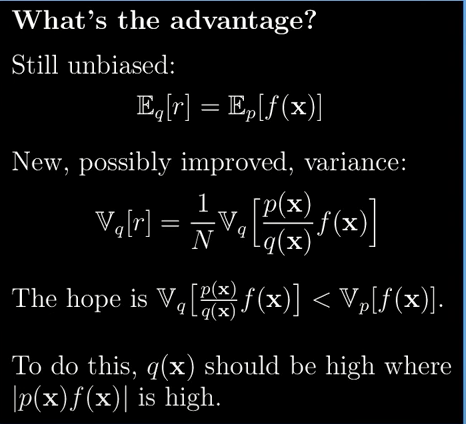


✅importance sampling의 장점은 해당 조건을 만족하는 q(x)가 존재할때,

q(x)의 Variance는 p의 Variance보다 작다는 것이다.

이로써 기존 p(x)에서 샘플을 추출할때의 표준오차(SE)보다 더 낮게 q(x)에서 샘플을 추출할 수 있어 더 정확한 sampling based inference를 할 수 있다는 장점이 있다. 또한 추출하기 어려운 p(x) form 을 뽑기 쉬운 q(x)를 통해 샘플링이 가능해진다는 것도 장점이다.

⭐ **요약하자면, Monte Carlo Simulation 의 SE를 줄여줌으로써 estimate error를 줄여줌**

In [34]:
def f_x(x):
  return 1/(1+np.exp(-x)) 

In [80]:
from scipy import stats
def distribution(mu=0,sigma=1):
  distribution = stats.norm(mu,sigma)
  return distribution

n = 5000
mu_target = 10
sigma_target = 5
mu_appro = 3
sigma_appro = 1

p_x = distribution(mu_target, sigma_target) # p_x 는 sample하기 어려운 분포라고 간주. 결과값 비교를 위해 여기서는 쉬운 정규분포로 작성.
q_x = distribution(mu_appro, sigma_appro) # q_x 가 sample하기 쉬운 분포라고 간주.

In [81]:
s_list = []
for i in range(n):
    # draw a sample
    x_i = np.random.normal(mu_target, sigma_target) # p_x 에서 추출한 샘플
    s = f_x(x_i)

    s_list.append(s)
print("simulate value", np.mean(s_list)) # true value

simulate value 0.9708216643894677


In [82]:
value_list = []
for i in range(n):
    # sample from q_x (sample하기 쉬운 분포에서 추출)
    x_i = np.random.normal(mu_appro, sigma_appro)
    value = f_x(x_i)*(p_x.pdf(x_i) / q_x.pdf(x_i))
    
    value_list.append(value)
print("average {} variance {}".format(np.mean(value_list), np.var(value_list)))

average 0.2484927750381907 variance 9.39575201045824


/usr/local/lib/python3.9/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.9/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


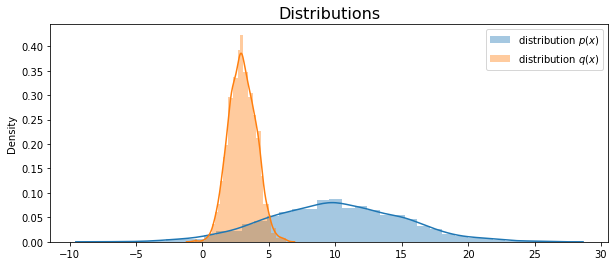

In [84]:
import seaborn as sns
plt.figure(figsize=[10, 4])
sns.distplot([np.random.normal(mu_target, sigma_target) for _ in range(3000)], label="distribution $p(x)$")
sns.distplot([np.random.normal(mu_appro, sigma_appro) for _ in range(3000)], label="distribution $q(x)$")
plt.title("Distributions", size=16)
plt.legend()

이는 $p(x)/q(x) = w(x)$에 해당하는 importance weight 이 boundary region으로 갈수록 $p(x)$ 가 커져서

boundary region으로 갈수록 weight가 높아져서더 해당 부분에서 더 많이 추출하기 때문. 

## 3. Markov Chain

In [85]:
import numpy as np
import random as rm


In [86]:
# The statespace
states = ["Sleep","Icecream","Run"]

# Possible sequences of events
transitionName = [["SS","SR","SI"],["RS","RR","RI"],["IS","IR","II"]]

# Probabilities matrix (transition matrix)
transitionMatrix = [[0.2,0.6,0.2],[0.1,0.6,0.3],[0.2,0.7,0.1]]


In [109]:
# A function that implements the Markov model to forecast the state/mood.
def activity_forecast(days):
    # Choose the starting state
    activityToday = "Sleep"
    print("Start state: " + activityToday)
    # Shall store the sequence of states taken. So, this only has the starting state for now.
    activityList = [activityToday]
    i = 0
    # To calculate the probability of the activityList
    prob = 1
    while i != days:
        if activityToday == "Sleep":
            change = np.random.choice(transitionName[0],replace=True,p=transitionMatrix[0])
            if change == "SS":
                prob = prob * 0.2
                activityList.append("Sleep")
                pass
            elif change == "SR":
                prob = prob * 0.6
                activityToday = "Run" # update
                activityList.append("Run")
            else:
                prob = prob * 0.2
                activityToday = "Icecream"
                activityList.append("Icecream")
        elif activityToday == "Run":
            change = np.random.choice(transitionName[1],replace=True,p=transitionMatrix[1])
            if change == "RR":
                prob = prob * 0.6
                activityList.append("Run")
                pass
            elif change == "RS":
                prob = prob * 0.1
                activityToday = "Sleep"
                activityList.append("Sleep")
            else:
                prob = prob * 0.3
                activityToday = "Icecream"
                activityList.append("Icecream")
        elif activityToday == "Icecream":
            change = np.random.choice(transitionName[2],replace=True,p=transitionMatrix[2])
            if change == "II":
                prob = prob * 0.1
                activityList.append("Icecream")
                pass
            elif change == "IS":
                prob = prob * 0.2
                activityToday = "Sleep"
                activityList.append("Sleep")
            else:
                prob = prob * 0.7
                activityToday = "Run"
                activityList.append("Run")
        i += 1
      
    print("Possible states: " + str(activityList))
    print("End state after "+ str(days) + " days: " + activityToday)
    print("Probability of the possible sequence of states: " + str(prob))

# Function that forecasts the possible state for the next 2 days
activity_forecast(2)


Start state: Sleep
Possible states: ['Sleep', 'Run', 'Run']
End state after 2 days: Run
Probability of the possible sequence of states: 0.36


In [112]:
def activity_forecast(days):
    # Choose the starting state
    activityToday = "Sleep"
    # Shall store the sequence of states taken. So, this only has the starting state for now.
    activityList = [activityToday]
    i = 0
    # To calculate the probability of the activityList
    prob = 1
    while i != days:
        if activityToday == "Sleep":
            change = np.random.choice(transitionName[0],replace=True,p=transitionMatrix[0])
            if change == "SS":
                prob = prob * 0.2
                activityList.append("Sleep")
                pass
            elif change == "SR":
                prob = prob * 0.6
                activityToday = "Run" # update
                activityList.append("Run")
            else:
                prob = prob * 0.2
                activityToday = "Icecream"
                activityList.append("Icecream")
        elif activityToday == "Run":
            change = np.random.choice(transitionName[1],replace=True,p=transitionMatrix[1])
            if change == "RR":
                prob = prob * 0.6
                activityList.append("Run")
                pass
            elif change == "RS":
                prob = prob * 0.1
                activityToday = "Sleep"
                activityList.append("Sleep")
            else:
                prob = prob * 0.3
                activityToday = "Icecream"
                activityList.append("Icecream")
        elif activityToday == "Icecream":
            change = np.random.choice(transitionName[2],replace=True,p=transitionMatrix[2])
            if change == "II":
                prob = prob * 0.1
                activityList.append("Icecream")
                pass
            elif change == "IS":
                prob = prob * 0.2
                activityToday = "Sleep"
                activityList.append("Sleep")
            else:
                prob = prob * 0.7
                activityToday = "Run"
                activityList.append("Run")
        i += 1
    return activityList

In [113]:
# To save every activityList
list_activity = []
count = 0

# `Range` starts from the first count up until but excluding the last count
for iterations in range(1,10000):
        list_activity.append(activity_forecast(2))

# Check out all the `activityList` we collected    
#print(list_activity)

# Iterate through the list to get a count of all activities ending in state:'Run'
for smaller_list in list_activity:
    if(smaller_list[2] == "Run"):
        count += 1

# Calculate the probability of starting from state:'Sleep' and ending at state:'Run'
percentage = (count/10000) * 100
print("The probability of starting at state:'Sleep' and ending at state:'Run'= " + str(percentage) + "%")

The probability of starting at state:'Sleep' and ending at state:'Run'= 61.09%
